In [1]:
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.corpus import movie_reviews
movie_reviews.words()

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus  import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re

In [91]:
data = pd.read_csv("/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv").sample(30000)
data.head()

,clean_text,category
65393,arre then why from 2012 till now wasn’ tested ...,0.0
149988,many leaders have fought from two places inclu...,1.0
47984,india stands tall space power narendra modi th...,0.0
26499,india\ncorruption the offices choukidar modi 3...,1.0
52027,ministry space handled modi himself,0.0


In [92]:
data['category'].value_counts()

category
 1.0    13202
 0.0    10184
-1.0     6614
Name: count, dtype: int64

### Downsampling

In [93]:
min_samples = data['category'].value_counts().min()
min_samples

6614

In [94]:
data = data.groupby('category').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

In [95]:
data['category'].value_counts()

category
-1.0    6614
 0.0    6614
 1.0    6614
Name: count, dtype: int64

In [96]:
data.isnull().sum()

clean_text    2
category      0
dtype: int64

In [97]:
data.dropna(inplace=True)

In [98]:
stemmer = PorterStemmer()

In [99]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [100]:
data['clean_text'] = data['clean_text'].apply(stemming)

In [101]:
data['category'] = data['category'].map({0.0:0.0, 1.0: 1, -1.0: 2})

In [102]:
X = data['clean_text'].values
y = data['category'].values

In [103]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [104]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [105]:
scores = []
for k in tqdm.tqdm(range(3, 22)):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(train_x, train_y)
    scores.append(knn.score(test_x, test_y))

100%|██████████| 19/19 [03:40<00:00, 11.62s/it]


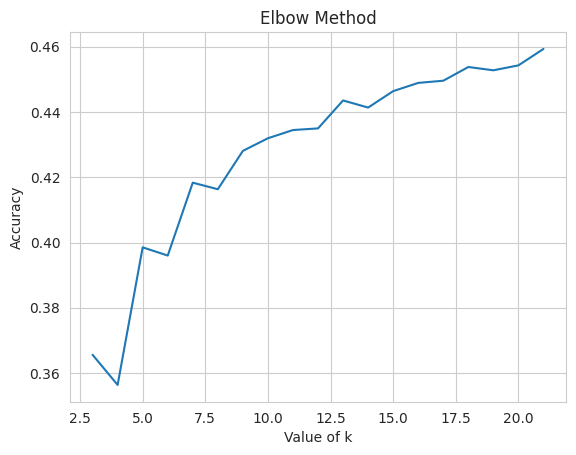

In [106]:
sns.set_style("whitegrid")
g=sns.lineplot(x=range(3, 22), y=scores)
 
g.set(xlabel ="Value of k",
      ylabel = "Accuracy",
      title ='Elbow Method')
 
plt.show()

In [107]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=21)

In [108]:
knn.score(test_x, test_y)

0.4593413978494624

In [109]:
with open('knn.pickle', 'wb') as f:
    pickle.dump(knn, f)

In [110]:
y_pred = knn.predict(test_x)
y_pred

array([0., 2., 0., ..., 0., 2., 0.])

In [111]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.93      0.55      1974
         1.0       0.72      0.25      0.37      1994
         2.0       0.74      0.20      0.31      1984

    accuracy                           0.46      5952
   macro avg       0.62      0.46      0.41      5952
weighted avg       0.62      0.46      0.41      5952



In [112]:
cm = confusion_matrix(test_y, y_pred)
cm

array([[1835,   81,   58],
       [1406,  504,   84],
       [1475,  114,  395]])

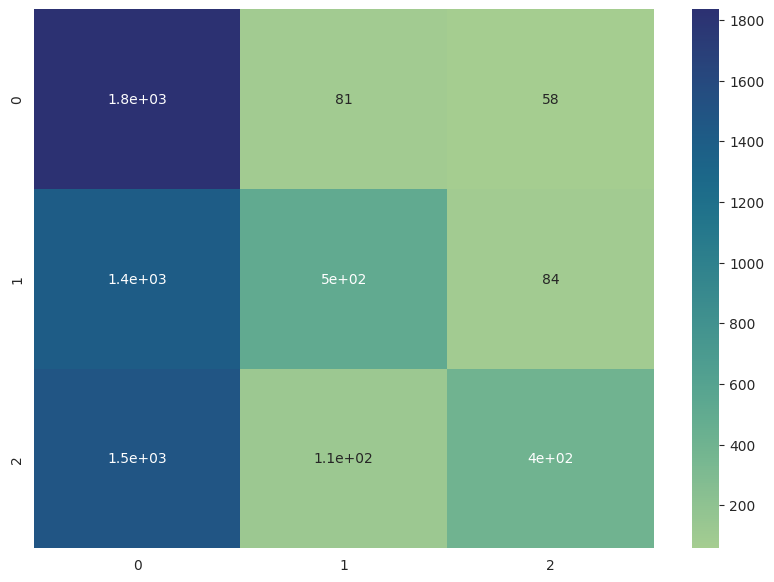

In [113]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, cmap='crest', annot=True)
plt.show()

It seems to have bias towards neutral comments. (Class 0)